**Capítulo 18 - Aprendizagem de reforço**

_Este notebook contém todo o código de exemplo e soluções para os exercícios do capítulo 18._

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml3/blob/main/18_reinforcement_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml3/blob/main/18_reinforcement_learning.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Setup

Este projeto requer Python 3.7 ou superior:

In [7]:
import sys

assert sys.version_info >= (3, 7)

E Tensorflow ≥ 2,8:

In [8]:
import tensorflow as tf

print("Versão do TensorFlow:", tf.__version__)

Versão do TensorFlow: 2.10.1


In [9]:
from packaging import version
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

Como fizemos nos capítulos anteriores, vamos definir os tamanhos de fonte padrão para tornar as figuras mais bonitas. Também vamos exibir algumas animações do Matplotlib, e há várias opções possíveis para fazer isso: usaremos a opção Javascript.

In [10]:
import matplotlib.animation
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('animation', html='jshtml')

E vamos criar a pasta images/rl (se ela ainda não existir) e definir a função save_fig() que é usada neste notebook para salvar as figuras em alta resolução para o livro:

In [11]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "rl"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Este capítulo pode ser muito lento sem uma GPU, portanto, certifique-se de que existe uma ou emita um aviso:

In [1]:
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if "kaggle_secrets" in sys.modules:
        print("Go to Settings > Accelerator and select GPU.")

NameError: name 'tf' is not defined

Vamos instalar a biblioteca `gym`, que fornece diversos ambientes para Aprendizagem por Reforço. Também vamos instalar as bibliotecas extras necessárias para ambientes de controle clássico (incluindo o `CartPole`, que usaremos em breve), além de ambientes `Box2D` e `Atari`, que são necessários para os exercícios.

**Observação:** Ao executar a célula a seguir, você aceita a licença da ROM `Atari`.  
**Note:** by running the following cell, you accept the Atari ROM license.

In [13]:
if "google.colab" in sys.modules or "kaggle_secrets" in sys.modules:
    %pip install -q -U gym
    %pip install -q -U gym[classic_control,box2d,atari,accept-rom-license]

# Introdução ao Openai Gym

Neste notebook, usaremos o OpenAI gym: [OpenAI gym](https://gym.openai.com/), um excelente conjunto de ferramentas para desenvolver e comparar algoritmos de Aprendizagem por Reforço. Ele fornece diversos ambientes para seus *agentes* de aprendizado interagirem. Vamos importar o Gym e criar um novo ambiente `CartPole`:


In [14]:
import gym

env = gym.make("CartPole-v1", render_mode="rgb_array")

O CartPole (versão 1) é um ambiente muito simples composto por um carrinho que pode se mover para a esquerda ou direita, e uma barra vertical colocada em cima dele. O agente deve mover o carrinho para a esquerda ou direita para manter a barra na vertical.

**Dica:** `gym.envs.registry` é um dicionário contendo todos os ambientes disponíveis:

In [15]:
# extra code – shows the first few environments
envs = gym.envs.registry
sorted(envs.keys())[:5] + ["..."]

['ALE/Adventure-ram-v5',
 'ALE/Adventure-v5',
 'ALE/AirRaid-ram-v5',
 'ALE/AirRaid-v5',
 'ALE/Alien-ram-v5',
 '...']

Os valores de registro são especificações de ambiente:

In [16]:
# extra code – shows the specification for the CartPole-v1 environment
envs["CartPole-v1"]

EnvSpec(id='CartPole-v1', entry_point='gym.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=475.0, nondeterministic=False, max_episode_steps=500, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={}, namespace=None, name='CartPole', version=1)

Vamos inicializar o ambiente chamando o método `reset()`. Isso retorna uma observação, bem como um dicionário que pode conter informações adicionais. Ambos são específicos do ambiente.

In [17]:
obs, info = env.reset(seed=42)
obs

array([ 0.0273956 , -0.00611216,  0.03585979,  0.0197368 ], dtype=float32)

In [18]:
info

{}

No caso do CartPole, cada observação é um array NumPy 1D composto por 4 números decimais: eles representam a posição horizontal do carrinho, sua velocidade, o ângulo do poste (0 = vertical) e a velocidade angular.

Um ambiente pode ser visualizado chamando seu método  `render()`. Se você definir `render_mode` como `"rgb_array"` ao criar o ambiente, isso retornará um array NumPy.

In [19]:
img = env.render()
img.shape  # height, width, channels (3 = Red, Green, Blue)

(400, 600, 3)

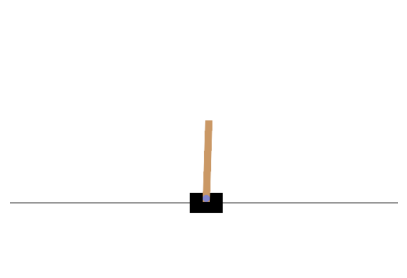

In [20]:
# extra code – creates a little function to render and plot an environment

def plot_environment(env, figsize=(5, 4)):
    plt.figure(figsize=figsize)
    img = env.render()
    plt.imshow(img)
    plt.axis("off")
    return img

plot_environment(env)
plt.show()

Vamos ver como interagir com um ambiente. Seu agente precisará selecionar uma ação a partir de um "action space" (o conjunto de ações possíveis). Vamos ver como é o espaço de ação deste ambiente:

In [21]:
env.action_space

Discrete(2)

Sim, apenas duas ações possíveis: acelerar para a esquerda (0) ou para a direita (1).

Como o poste está inclinado para a direita (obs[2] > 0), vamos acelerar o carrinho para a direita:

In [22]:
action = 1  # accelerate right
obs, reward, done, truncated, info = env.step(action)
obs

array([ 0.02727336,  0.18847767,  0.03625453, -0.26141977], dtype=float32)

Observe que o carrinho agora está se movendo para a direita (`obs[1] > 0`). O poste ainda está inclinado para a direita (`obs[2] > 0`), mas sua velocidade angular agora é negativa (`obs[3] < 0`), então é provável que ele se incline para a esquerda após o próximo passo.

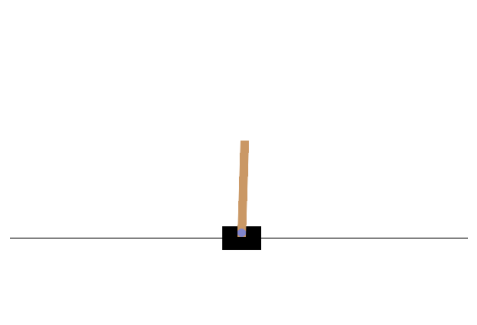

In [23]:
# extra code – displays the environment
plot_environment(env)
save_fig("cart_pole_plot")
plt.show()

Parece que está fazendo o que estamos instruindo!

O ambiente também informa ao agente quanto de recompensa ele obteve durante a última etapa:

In [24]:
reward

1.0

Quando o jogo termina, o ambiente retorna `done=True`. Neste caso, ainda não terminou:

In [25]:
done

False

Alguns wrappers de ambiente podem querer interromper o ambiente antecipadamente. Por exemplo, quando um limite de tempo é atingido ou quando um objeto sai dos limites. Neste caso, `truncated` será definido como `True`. Neste caso, ainda não foi truncado:

In [26]:
truncated

False

Finalmente, `info` é um dicionário específico do ambiente que pode fornecer algumas informações extras que podem ser úteis para depuração ou treinamento. Por exemplo, em alguns jogos, pode indicar quantas vidas o agente possui.

In [27]:
info

{}

A sequência de passos entre o momento em que o ambiente é redefinido até que esteja concluído ou truncado é chamada de "episódio". No final de um episódio (ou seja, quando `step()`) retorna `done=True` ou `truncated=True`), você deve redefinir o ambiente antes de continuar a usá-lo.

In [28]:
if done or truncated:
    obs, info = env.reset()

Agora, como podemos manter o poste em pé? Precisaremos definir uma _policy_ para isso. Esta é a estratégia que o agente usará para selecionar uma ação a cada passo. Ele pode usar todas as ações e observações passadas para decidir o que fazer.

# Uma política codificada simples

Vamos codificar uma estratégia simples: se o poste estiver inclinado para a esquerda, empurre o carrinho para a esquerda, e vice versa. Vamos ver se isso funciona:

In [29]:
def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

totals = []
for episode in range(500):
    episode_rewards = 0
    obs, info = env.reset(seed=episode)
    for step in range(200):
        action = basic_policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        episode_rewards += reward
        if done or truncated:
            break

    totals.append(episode_rewards)

In [30]:
import numpy as np

np.mean(totals), np.std(totals), min(totals), max(totals)

(41.698, 8.389445512070509, 24.0, 63.0)

Bem, como esperado, essa estratégia é um pouco básica demais: o melhor que ela fez foi manter o poste em pé por apenas 63 passos. Este ambiente é considerado resolvido quando o agente mantém o poste em pé por 200 passos.

Vamos visualizar um episódio. Você pode aprender mais sobre animações no Matplotlib no [Matplotlib tutorial notebook](tools_matplotlib.ipynb#Animations).


In [31]:
# extra code – this cell displays an animation of one episode

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = matplotlib.animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

def show_one_episode(policy, n_max_steps=200, seed=42):
    frames = []
    env = gym.make("CartPole-v1", render_mode="rgb_array")
    np.random.seed(seed)
    obs, info = env.reset(seed=seed)
    for step in range(n_max_steps):
        frames.append(env.render())
        action = policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        if done or truncated:
            break
    env.close()
    return plot_animation(frames)

show_one_episode(basic_policy)

Claramente, o sistema é instável e, após apenas alguns balanços, o poste acaba muito inclinado: jogo encerrado. Precisaremos ser mais inteligentes do que isso!

# Políticas de rede neural (Neural Network Policies)

Vamos criar uma rede neural que receberá as observações como entradas e fornecerá as probabilidades das ações a serem tomadas para cada observação. Para escolher uma ação, a rede estimará uma probabilidade para cada ação, e então selecionaremos uma ação aleatoriamente de acordo com as probabilidades estimadas. No caso do ambiente CartPole, existem apenas duas ações possíveis (esquerda ou direita), então só precisamos de um neurônio de saída: ele fornecerá a probabilidade `p` da ação 0 (esquerda), e, é claro, a probabilidade da ação 1 (direita) será `1 - p`.

In [32]:
import tensorflow as tf

tf.random.set_seed(42)  # extra code – ensures reproducibility on the CPU

model = tf.keras.Sequential([
    tf.keras.layers.Dense(5, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])

Nesse ambiente em particular, as ações e observações passadas podem ser ignoradas com segurança, uma vez que cada observação contém o estado completo do ambiente.Se houvesse algum estado oculto, pode ser necessário considerar ações e observações anteriores para tentar inferir o estado oculto do meio ambiente.Por exemplo, se o ambiente revelasse apenas a posição do carrinho, mas não sua velocidade, você teria que considerar não apenas a observação atual, mas também a observação anterior para estimar a velocidade atual.Outro exemplo é se as observações são barulhentas: você pode usar as últimas observações para estimar o estado atual mais provável.Nosso problema é, portanto, tão simples quanto pode ser: a observação atual é livre de ruído e contém o estado completo do ambiente.

Você pode se perguntar por que planejamos escolher uma ação aleatória com base na probabilidade dada pela rede de políticas, em vez de apenas escolher a ação com a maior probabilidade.Essa abordagem permite que o agente encontre o equilíbrio certo entre _exploring_ novas ações e _exploiting_ as ações que são conhecidas por funcionar bem.Aqui está uma analogia: suponha que você vá a um restaurante pela primeira vez, e todos os pratos parecem igualmente atraentes para que você escolha aleatoriamente um.Se for bom, você pode aumentar a probabilidade de encomendá -lo na próxima vez, mas não deve aumentar essa probabilidade para 100%, ou então nunca experimentará os outros pratos, alguns dos quais podem ser ainda melhores do queaquele que você tentou.

Vamos escrever uma pequena função de política que usará a rede neural para obter a probabilidade de mover para a esquerda, e depois vamos usá-la para executar um episódio:

In [33]:
# extra code – a function that creates an animation for a given policy model

def pg_policy(obs):
    left_proba = model.predict(obs[np.newaxis], verbose=0)
    return int(np.random.rand() > left_proba)

np.random.seed(42)
show_one_episode(pg_policy)

Sim, realmente ruim. A rede neural terá que aprender a fazer melhor. Primeiro, vamos ver se ela é capaz de aprender a política básica que usamos anteriormente: ir para a esquerda se o poste estiver inclinado para a esquerda, e ir para a direita se estiver inclinado para a direita.

Vamos ver se ela pode aprender uma política melhor por conta própria. Uma que não balance tanto.

# Gradientes de política(Policy Gradients)

Para treinar esta rede neural, precisamos definir as probabilidades de destino **y**.Se uma ação for boa, devemos aumentar sua probabilidade e, inversamente, se for ruim, devemos reduzi -la.Mas como sabemos se uma ação é boa ou ruim?O problema é que a maioria das ações tem efeitos atrasados; portanto, quando você ganha ou perde pontos em um episódio, não está claro quais ações contribuíram para esse resultado: foi apenas a última ação?Ou os últimos 10?Ou apenas uma ação 50 etapas antes?Isso é chamado de problema de atribuição _credit.

O algoritmo _policy gradientes_ aborda esse problema ao reproduzir vários episódios, tornando as ações quase positivas para recompensas positivas um pouco mais propensas, enquanto as ações próximas a recompensas negativas são um pouco menos propensas.Primeiro jogamos, depois voltamos e pensamos no que fizemos.

Vamos começar criando uma função para jogar um único passo usando o modelo. Também vamos fingir, por enquanto, que qualquer ação que ele tome é a correta, para que possamos calcular a perda e seus gradientes. Vamos apenas salvar esses gradientes por enquanto e modificá-los posteriormente, dependendo de quão boa ou ruim a ação se mostrar.

In [34]:
def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        left_proba = model(obs[np.newaxis])
        action = (tf.random.uniform([1, 1]) > left_proba)
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32)
        loss = tf.reduce_mean(loss_fn(y_target, left_proba))

    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, truncated, info = env.step(int(action))
    return obs, reward, done, truncated, grads

Se `left_proba` for alto, então `action` provavelmente será `False` (já que um número aleatório uniformemente amostrado entre 0 e 1 provavelmente não será maior que `left_proba`). E `False` significa 0 quando você o converte para um número, então `y_target` seria igual a 1 - 0 = 1. Em outras palavras, definimos o alvo como 1, o que significa que estamos fingindo que a probabilidade de ir para a esquerda deveria ter sido 100% (portanto, escolhemos a ação à direita).



Agora, vamos criar outra função que dependerá da função `play_one_step()` para jogar vários episódios, retornando todas as recompensas e gradientes, para cada episódio e cada passo:


In [35]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs, info = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, truncated, grads = play_one_step(
                env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done or truncated:
                break

        all_rewards.append(current_rewards)
        all_grads.append(current_grads)

    return all_rewards, all_grads

O algoritmo de gradientes de políticas usa o modelo para reproduzir o episódio várias vezes (por exemplo, 10 vezes), então ele volta e analisa todas as recompensas, os desconta e os normaliza.Então, vamos criar funções de casal para isso: o primeiro calculará recompensas com desconto;O segundo normalizará as recompensas com desconto em muitos episódios.

In [36]:
def discount_rewards(rewards, discount_factor):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_factor
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_factor):
    all_discounted_rewards = [discount_rewards(rewards, discount_factor)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]

Digamos que houve três ações e, após cada ação, houve uma recompensa: 10 primeiros, depois 0 e depois -50.Se usarmos um fator de desconto de 80%, a terceira ação receberá -50 (crédito total pela última recompensa), mas a segunda ação receberá apenas -40 (80% de crédito pela última recompensa) e a 1ª açãoreceberá 80% de -40 (-32) mais crédito total pela primeira recompensa (+10), o que leva a uma recompensa com desconto de -22:

In [37]:
discount_rewards([10, 0, -50], discount_factor=0.8)

array([-22, -40, -50])

Para normalizar todas as recompensas com desconto em todos os episódios, calculamos a média e o desvio padrão de todas as recompensas com desconto e subtraímos a média de cada recompensa com desconto e dividirá pelo desvio padrão:

In [38]:
discount_and_normalize_rewards([[10, 0, -50], [10, 20]],
                               discount_factor=0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

In [39]:
n_iterations = 150
n_episodes_per_update = 10
n_max_steps = 200
discount_factor = 0.95

In [40]:
# extra code – let's create the neural net and reset the environment, for
#              reproducibility

tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(5, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])

obs, info = env.reset(seed=42)

In [41]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.01)
loss_fn = tf.keras.losses.binary_crossentropy

In [42]:
for iteration in range(n_iterations):
    all_rewards, all_grads = play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, model, loss_fn)

    # extra code – displays some debug info during training
    total_rewards = sum(map(sum, all_rewards))
    print(f"\rIteration: {iteration + 1}/{n_iterations},"
          f" mean rewards: {total_rewards / n_episodes_per_update:.1f}", end="")

    all_final_rewards = discount_and_normalize_rewards(all_rewards,
                                                       discount_factor)
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
             for episode_index, final_rewards in enumerate(all_final_rewards)
                 for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)

    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

Iteration: 98/150, mean rewards: 182.3

In [ ]:
# extra code – displays the animation
np.random.seed(42)
show_one_episode(pg_policy)

/tmp/ipykernel_14610/2771988920.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(np.random.rand() > left_proba)
/media/dayvson/dados/03_biblioteca/livros_materiais_de_apoio/handson-ml3/.venv/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


# Material extra - Cadeias de Markov (Markov Chains)

As seguintes probabilidades de transição correspondem à cadeia de Markov representada na Figura 18–7.Vamos executar este processo estocástico algumas vezes para ver como é:

In [ ]:
np.random.seed(42)

transition_probabilities = [ # shape=[s, s']
        [0.7, 0.2, 0.0, 0.1],  # from s0 to s0, s1, s2, s3
        [0.0, 0.0, 0.9, 0.1],  # from s1 to s0, s1, s2, s3
        [0.0, 1.0, 0.0, 0.0],  # from s2 to s0, s1, s2, s3
        [0.0, 0.0, 0.0, 1.0]]  # from s3 to s0, s1, s2, s3

n_max_steps = 1000  # to avoid blocking in case of an infinite loop
terminal_states = [3]

def run_chain(start_state):
    current_state = start_state
    for step in range(n_max_steps):
        print(current_state, end=" ")
        if current_state in terminal_states:
            break
        current_state = np.random.choice(
            range(len(transition_probabilities)),
            p=transition_probabilities[current_state]
        )
    else:
        print("...", end="")

    print()

for idx in range(10):
    print(f"Run #{idx + 1}: ", end="")
    run_chain(start_state=0)

Run #1: 0 0 3 
Run #2: 0 1 2 1 2 1 2 1 2 1 3 
Run #3: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
Run #4: 0 3 
Run #5: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
Run #6: 0 1 3 
Run #7: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
Run #8: 0 0 0 1 2 1 2 1 3 
Run #9: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
Run #10: 0 0 0 1 2 1 3 


# Processo de decisão de Markov (Markov Decision Process)

Vamos definir algumas probabilidades de transição, recompensas e possíveis ações.Por exemplo, no estado S0, se a ação A0 for escolhida, com o proba 0,7 iremos para o estado S0 com recompensa +10, com probabilidade 0,3 iremos para o estado S1 sem recompensa e nunca ir para o estado S2 (de modo que oAs probabilidades de transição são `[0,7, 0,3, 0,0]`, e as recompensas são `[+10, 0, 0]`):

In [ ]:
transition_probabilities = [  # shape=[s, a, s']
    [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],
    [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]],
    [None, [0.8, 0.1, 0.1], None]
]
rewards = [  # shape=[s, a, s']
    [[+10, 0, 0], [0, 0, 0], [0, 0, 0]],
    [[0, 0, 0], [0, 0, 0], [0, 0, -50]],
    [[0, 0, 0], [+40, 0, 0], [0, 0, 0]]
]
possible_actions = [[0, 1, 2], [0, 2], [1]]

# Iteração Q-valor (Q-Value Iteration)

In [ ]:
Q_values = np.full((3, 3), -np.inf)  # -np.inf for impossible actions
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0  # for all possible actions

In [ ]:
gamma = 0.90  # the discount factor

history1 = []  # extra code – needed for the figure below
for iteration in range(50):
    Q_prev = Q_values.copy()
    history1.append(Q_prev) # extra code
    for s in range(3):
        for a in possible_actions[s]:
            Q_values[s, a] = np.sum([
                    transition_probabilities[s][a][sp]
                    * (rewards[s][a][sp] + gamma * Q_prev[sp].max())
                for sp in range(3)])

history1 = np.array(history1)  # extra code

In [ ]:
Q_values

array([[18.91891892, 17.02702702, 13.62162162],
       [ 0.        ,        -inf, -4.87971488],
       [       -inf, 50.13365013,        -inf]])

In [ ]:
Q_values.argmax(axis=1)  # optimal action for each state

array([0, 0, 1])

A política ideal para este MDP, ao usar um fator de desconto de 0,90, é escolher a ação A0 quando no estado S0 e escolher a ação A0 quando no estado S1 e finalmente escolher a ação A1 (a única ação possível) quando estiver no estado S2.Se você tentar novamente com um fator de desconto de 0,95 em vez de 0,90, descobrirá que a ação ideal para o estado S1 se tornará A2.Isso ocorre porque o fator de desconto é maior, portanto, o agente valoriza mais o futuro e, portanto, está pronto para pagar uma penalidade imediata para obter mais recompensas futuras.

# Q-learning

O Q-Learning funciona assistindo a um agente jogar (por exemplo, aleatoriamente) e melhorando gradualmente suas estimativas dos valores Q.Uma vez que possui estimativas precisas de valor Q (ou próximo o suficiente), a política ideal consiste na escolha da ação que possui o maior valor Q (ou seja, a política gananciosa).

Precisamos simular um agente que se move no ambiente, então vamos definir uma função para executar alguma ação e obter o novo estado e uma recompensa:

In [ ]:
def step(state, action):
    probas = transition_probabilities[state][action]
    next_state = np.random.choice([0, 1, 2], p=probas)
    reward = rewards[state][action][next_state]
    return next_state, reward

Também precisamos de uma política de exploração, que pode ser qualquer política, desde que visite todo estado possível muitas vezes.Vamos apenas usar uma política aleatória, já que o espaço do estado é muito pequeno:

In [ ]:
def exploration_policy(state):
    return np.random.choice(possible_actions[state])

Agora, vamos inicializar Q-Values como antes e executar o algoritmo Q-Learning:

In [ ]:
# extra code – initializes the Q-Values, just like earlier
np.random.seed(42)
Q_values = np.full((3, 3), -np.inf)
for state, actions in enumerate(possible_actions):
    Q_values[state][actions] = 0

In [ ]:
alpha0 = 0.05  # initial learning rate
decay = 0.005  # learning rate decay
gamma = 0.90  # discount factor
state = 0  # initial state
history2 = []  # extra code – needed for the figure below

for iteration in range(10_000):
    history2.append(Q_values.copy())  # extra code
    action = exploration_policy(state)
    next_state, reward = step(state, action)
    next_value = Q_values[next_state].max()  # greedy policy at the next step
    alpha = alpha0 / (1 + iteration * decay)
    Q_values[state, action] *= 1 - alpha
    Q_values[state, action] += alpha * (reward + gamma * next_value)
    state = next_state

history2 = np.array(history2)  # extra code

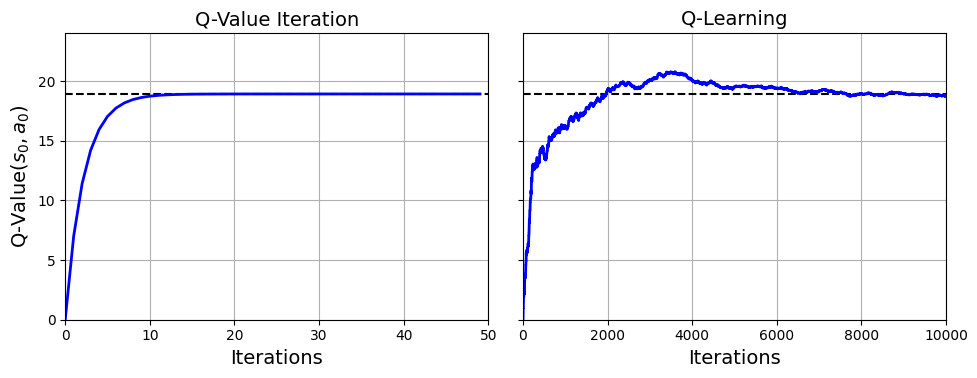

In [ ]:
# extra code – this cell generates and saves Figure 18–9

true_Q_value = history1[-1, 0, 0]

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
axes[0].set_ylabel("Q-Value$(s_0, a_0)$", fontsize=14)
axes[0].set_title("Q-Value Iteration", fontsize=14)
axes[1].set_title("Q-Learning", fontsize=14)
for ax, width, history in zip(axes, (50, 10000), (history1, history2)):
    ax.plot([0, width], [true_Q_value, true_Q_value], "k--")
    ax.plot(np.arange(width), history[:, 0, 0], "b-", linewidth=2)
    ax.set_xlabel("Iterations", fontsize=14)
    ax.axis([0, width, 0, 24])
    ax.grid(True)

save_fig("q_value_plot")
plt.show()

# Deep Q-Network

Vamos construir o DQN. Dado um estado, ele estimará, para cada ação possível, a soma das recompensas futuras com desconto que pode esperar depois de reproduzir essa ação (mas antes de ver seu resultado):

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on the CPU

input_shape = [4]  # == env.observation_space.shape
n_outputs = 2  # == env.action_space.n

model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation="elu", input_shape=input_shape),
    tf.keras.layers.Dense(32, activation="elu"),
    tf.keras.layers.Dense(n_outputs)
])

Para selecionar uma ação usando este DQN, apenas escolhemos a ação com o maior valor Q previsto.No entanto, para garantir que o agente explore o ambiente, escolhemos uma ação aleatória com probabilidade `epsilon`.

In [ ]:
def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)  # random action
    else:
        Q_values = model.predict(state[np.newaxis], verbose=0)[0]
        return Q_values.argmax()  # optimal action according to the DQN

Também precisaremos de um buffer de repetição.Ele conterá as experiências do agente, na forma de tuplas: `(obs, action, reward, next_obs, done)`.Podemos usar a classe `deque` para isso:

In [ ]:
from collections import deque

replay_buffer = deque(maxlen=2000)

**Nota**: Para buffers de repetição muito grandes, você pode usar um buffer circular, pois o tempo de acesso aleatório será O (1) em vez de O (n).Ou você pode conferir o DeepMind [Reverb Library](https://github.com/deepmind/Reverb).

In [ ]:
# extra code – A basic circular buffer implementation

class ReplayBuffer:
    def __init__(self, max_size):
        self.buffer = np.empty(max_size, dtype=object)
        self.max_size = max_size
        self.index = 0
        self.size = 0

    def append(self, obj):
        self.buffer[self.index] = obj
        self.size = min(self.size + 1, self.max_size)
        self.index = (self.index + 1) % self.max_size

    def sample(self, batch_size):
        indices = np.random.randint(self.size, size=batch_size)
        return self.buffer[indices]

E vamos criar uma função para amostrar experiências a partir do buffer de repetição.Ele retornará 6 matrizes numpy: `[obs, actions, rewards, next_obs, dones, truncateds]`.

In [ ]:
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    batch = [replay_buffer[index] for index in indices]
    return [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(6)
    ]  # [states, actions, rewards, next_states, dones, truncateds]

Agora, podemos criar uma função que usará o DQN para jogar uma etapa e gravar sua experiência no buffer de repetição:

In [ ]:
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, truncated, info = env.step(action)
    replay_buffer.append((state, action, reward, next_state, done, truncated))
    return next_state, reward, done, truncated, info

Por fim, vamos criar uma função que experimente algumas experiências do buffer de repetição e executará uma etapa de treinamento:

In [ ]:
# extra code – for reproducibility, and to generate the next figure
env.reset(seed=42)
np.random.seed(42)
tf.random.set_seed(42)
rewards = [] 
best_score = 0

In [ ]:
batch_size = 32
discount_factor = 0.95
optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-2)
loss_fn = tf.keras.losses.mean_squared_error

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones, truncateds = experiences
    next_Q_values = model.predict(next_states, verbose=0)
    max_next_Q_values = next_Q_values.max(axis=1)
    runs = 1.0 - (dones | truncateds)  # episode is not done or truncated
    target_Q_values = rewards + runs * discount_factor * max_next_Q_values
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

E agora, vamos treinar o modelo!

In [ ]:
for episode in range(600):
    obs, info = env.reset()    
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, truncated, info = play_one_step(env, obs, epsilon)
        if done or truncated:
            break

    # extra code – displays debug info, stores data for the next figure, and
    #              keeps track of the best model weights so far
    print(f"\rEpisode: {episode + 1}, Steps: {step + 1}, eps: {epsilon:.3f}",
          end="")
    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step

    if episode > 50:
        training_step(batch_size)

model.set_weights(best_weights)  # extra code – restores the best model weights

NameError: name 'env' is not defined

In [ ]:
# extra code – this cell generates and saves Figure 18–10
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.grid(True)
save_fig("dqn_rewards_plot")
plt.show()

In [ ]:
# extra code – shows an animation of the trained DQN playing one episode
show_one_episode(epsilon_greedy_policy)

Nada mal!😀

## Metas de Q-value fixo (Fixed Q-Value Targets)

Vamos criar o DQN online:

In [ ]:
# extra code – creates the same DQN model as earlier

tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation="elu", input_shape=input_shape),
    tf.keras.layers.Dense(32, activation="elu"),
    tf.keras.layers.Dense(n_outputs)
])

Agora crie o DQN de destino: é apenas um clone do DQN online:

In [ ]:
target = tf.keras.models.clone_model(model)  # clone the model's architecture
target.set_weights(model.get_weights())  # copy the weights

Em seguida, usamos o mesmo código acima, exceto pela linha marcada com `# <= CHANGED`:

In [ ]:
env.reset(seed=42)
np.random.seed(42)
tf.random.set_seed(42)
rewards = [] 
best_score = 0

batch_size = 32
discount_factor = 0.95
optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-2)
loss_fn = tf.keras.losses.mean_squared_error

replay_buffer = deque(maxlen=2000)  # resets the replay buffer

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones, truncateds = experiences
    next_Q_values = target.predict(next_states, verbose=0)  # <= CHANGED
    max_next_Q_values = next_Q_values.max(axis=1)
    runs = 1.0 - (dones | truncateds)  # episode is not done or truncated
    target_Q_values = rewards + runs * discount_factor * max_next_Q_values
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

Novamente, este é o mesmo código do anterior, exceto pelas linhas marcadas com `# <= CHANGED`:

In [ ]:
for episode in range(600):
    obs, info = env.reset()    
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info, truncated = play_one_step(env, obs, epsilon)
        if done or truncated:
            break

    # extra code – displays debug info, stores data for the next figure, and
    #              keeps track of the best model weights so far
    print(f"\rEpisode: {episode + 1}, Steps: {step + 1}, eps: {epsilon:.3f}",
          end="")
    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step

    if episode > 50:
        training_step(batch_size)
        if episode % 50 == 0:                        # <= CHANGED
            target.set_weights(model.get_weights())  # <= CHANGED

    # Alternatively, you can do soft updates at each step:
    #if episode > 50:
        #training_step(batch_size)
        #target_weights = target.get_weights()
        #online_weights = model.get_weights()
        #for index, online_weight in enumerate(online_weights):
        #    target_weights[index] = (0.99 * target_weights[index]
        #                             + 0.01 * online_weight)
        #target.set_weights(target_weights)

model.set_weights(best_weights)  # extra code – restores the best model weights

In [ ]:
# extra code – this cell plots the learning curve
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.grid(True)
plt.show()

In [ ]:
# extra code – shows an animation of the trained DQN playing one episode
show_one_episode(epsilon_greedy_policy)

## Duplo DQN

O código é exatamente o mesmo que para alvos fixos de valor Q, exceto para a seção marcada como alterada na função `training_step()`:

In [ ]:
tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation="elu", input_shape=input_shape),
    tf.keras.layers.Dense(32, activation="elu"),
    tf.keras.layers.Dense(n_outputs)
])

target = tf.keras.models.clone_model(model)  # clone the model's architecture
target.set_weights(model.get_weights())  # copy the weights

env.reset(seed=42)
np.random.seed(42)
tf.random.set_seed(42)
rewards = [] 
best_score = 0

batch_size = 32
discount_factor = 0.95
optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-2)
loss_fn = tf.keras.losses.mean_squared_error

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones, truncateds = experiences

    #################### CHANGED SECTION ####################
    next_Q_values = model.predict(next_states, verbose=0)  # ≠ target.predict()
    best_next_actions = next_Q_values.argmax(axis=1)
    next_mask = tf.one_hot(best_next_actions, n_outputs).numpy()
    max_next_Q_values = (target.predict(next_states, verbose=0) * next_mask
                        ).sum(axis=1)
    #########################################################

    runs = 1.0 - (dones | truncateds)  # episode is not done or truncated
    target_Q_values = rewards + runs * discount_factor * max_next_Q_values
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

replay_buffer = deque(maxlen=2000)

for episode in range(600):
    obs, info = env.reset()    
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info, truncated = play_one_step(env, obs, epsilon)
        if done or truncated:
            break

    print(f"\rEpisode: {episode + 1}, Steps: {step + 1}, eps: {epsilon:.3f}",
          end="")
    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step

    if episode > 50:
        training_step(batch_size)
        if episode % 50 == 0:
            target.set_weights(model.get_weights())

model.set_weights(best_weights)

In [ ]:
# extra code – this cell plots the learning curve
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.grid(True)
plt.show()

In [ ]:
# extra code – shows an animation of the trained DQN playing one episode
show_one_episode(epsilon_greedy_policy)

# Duelo DQN Duplo

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on the CPU

input_states = tf.keras.layers.Input(shape=[4])
hidden1 = tf.keras.layers.Dense(32, activation="elu")(input_states)
hidden2 = tf.keras.layers.Dense(32, activation="elu")(hidden1)
state_values = tf.keras.layers.Dense(1)(hidden2)
raw_advantages = tf.keras.layers.Dense(n_outputs)(hidden2)
advantages = raw_advantages - tf.reduce_max(raw_advantages, axis=1,
                                            keepdims=True)
Q_values = state_values + advantages
model = tf.keras.Model(inputs=[input_states], outputs=[Q_values])

O resto é o mesmo código que anterior:

In [ ]:
# extra code – trains the model

batch_size = 32
discount_factor = 0.95
optimizer = tf.keras.optimizers.Nadam(learning_rate=5e-3)
loss_fn = tf.keras.losses.mean_squared_error

target = tf.keras.models.clone_model(model)  # clone the model's architecture
target.set_weights(model.get_weights())  # copy the weights

env.reset(seed=42)
replay_buffer = deque(maxlen=2000)
rewards = []
best_score = 0

for episode in range(600):
    obs, info = env.reset()    
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info, truncated = play_one_step(env, obs, epsilon)
        if done or truncated:
            break

    print(f"\rEpisode: {episode + 1}, Steps: {step + 1}, eps: {epsilon:.3f}",
          end="")
    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step

    if episode > 50:
        training_step(batch_size)
        if episode % 50 == 0:
            target.set_weights(model.get_weights())

model.set_weights(best_weights)

In [ ]:
# extra code – this cell plots the learning curve
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.grid(True)
plt.show()

In [ ]:
# extra code – shows an animation of the trained DQN playing one episode
show_one_episode(epsilon_greedy_policy)

Parece um agente bastante robusto!

In [ ]:
env.close()

# Soluções de exercícios

## 1. a 7.

1. O aprendizado de reforço é uma área de aprendizado de máquina que visa criar agentes capazes de tomar ações em um ambiente de uma maneira que maximize as recompensas com o tempo. Existem muitas diferenças entre a RL e o aprendizado supervisionado regular e não supervisionado. Aqui estão alguns:
    * Na aprendizagem supervisionada e não supervisionada, o objetivo é geralmente encontrar padrões nos dados e usá -los para fazer previsões. No aprendizado de reforço, o objetivo é encontrar uma boa política.
    * Ao contrário da aprendizagem supervisionada, o agente não recebe explicitamente a resposta "correta". Deve aprender por tentativa e erro.
    * Ao contrário da aprendizagem não supervisionada, há uma forma de supervisão, através de recompensas. Não dizemos ao agente como executar a tarefa, mas dizemos quando ela está progredindo ou quando está falhando..
    * Um agente de aprendizado de reforço precisa encontrar o equilíbrio certo entre explorar o meio ambiente, procurando novas maneiras de obter recompensas e explorar fontes de recompensas que ele já conhece. Por outro lado, os sistemas de aprendizagem supervisionados e não supervisionados geralmente não precisam se preocupar com a exploração; Eles apenas se alimentam dos dados de treinamento que recebem.
    * Na aprendizagem supervisionada e não supervisionada, as instâncias de treinamento são tipicamente independentes (na verdade, elas geralmente são embaralhadas). No aprendizado de reforço, as observações consecutivas geralmente não são independentes. Um agente pode permanecer na mesma região do ambiente por um tempo antes de seguir em frente, portanto, observações consecutivas serão muito correlacionadas. Em alguns casos, um buffer de repetição (memória) é usado para garantir que o algoritmo de treinamento obtenha observações bastante independentes.
2. Aqui estão algumas aplicações possíveis de aprendizado de reforço, exceto as mencionadas no Capítulo 18:
    * Personalização musical: o ambiente é o rádio da web personalizado do usuário. O agente é o software que decide qual música tocar a seguir para esse usuário. Suas ações possíveis são tocar qualquer música no catálogo (ela deve tentar escolher uma música que o usuário desfrutará) ou tocar um anúncio (deve tentar escolher um anúncio no qual o usuário estará interessado). Ele recebe uma pequena recompensa toda vez que o usuário ouve uma música, uma recompensa maior toda vez que o usuário ouve um anúncio, uma recompensa negativa quando o usuário pula uma música ou um anúncio e uma recompensa muito negativa se o usuário sair.
    * Marketing: o meio ambiente é o departamento de marketing da sua empresa. O agente é o software que define quais clientes uma campanha de discussão deve ser enviada, dado seu perfil e histórico de compra (para cada cliente, possui duas ações possíveis: enviar ou não enviar). Ele recebe uma recompensa negativa pelo custo da campanha de correspondência e uma recompensa positiva pela receita estimada gerada a partir desta campanha.
    * Entrega do produto: deixe o agente controlar uma frota de caminhões de entrega, decidindo o que eles devem pegar nos depósitos, para onde devem ir, o que devem cair e assim por diante. Ele receberá recompensas positivas para cada produto entregue no prazo e recompensas negativas para entregas tardias.
3. Ao estimar o valor de uma ação, os algoritmos de aprendizado de reforço normalmente resumem todas as recompensas a que essa ação levou, dando mais peso a recompensas imediatas e menos peso às recompensas posteriores (considerando que uma ação tem mais influência no futuro próximo do que no distante futuro). Para modelar isso, um fator de desconto é normalmente aplicado em cada etapa do tempo. Por exemplo, com um fator de desconto de 0,9, uma recompensa de 100 que é recebida duas etapas depois é contada como apenas 0,9 <sup> 2 </sup> × 100 = 81 quando você está estimando o valor da ação. Você pode pensar no fator de desconto como uma medida de quanto o futuro é valorizado em relação ao presente: se estiver muito próximo de 1, o futuro será avaliado quase tanto quanto o presente; Se estiver perto de 0, apenas as recompensas imediatas são matéria. Obviamente, isso afeta tremendamente a política ideal: se você valoriza o futuro, poderá estar disposto a suportar muita dor imediata para a perspectiva de eventuais recompensas, enquanto que, se você não valorizar o futuro, você apenas pegará Qualquer recompensa imediata que você possa encontrar, nunca investindo no futuro.
​
4. Para medir o desempenho de um agente de aprendizado de reforço, você pode simplesmente resumir as recompensas que recebe. Em um ambiente simulado, você pode executar muitos episódios e analisar as recompensas totais que ele obtém em média (e possivelmente analisar o MIN, o máximo, o desvio padrão etc.).
5. O problema da atribuição de crédito é o fato de que, quando um agente de aprendizado de reforço recebe uma recompensa, ele não tem uma maneira direta de saber qual de suas ações anteriores contribuiu para essa recompensa. Normalmente, ocorre quando há um grande atraso entre uma ação e a recompensa resultante (por exemplo, durante um jogo de _pong_ de Atari, pode haver algumas dezenas de tempo entre o momento em que o agente atinge a bola e o momento em que ganha o ponto) . Uma maneira de aliviá-lo é fornecer ao agente recompensas de curto prazo, quando possível. Isso geralmente requer conhecimento prévio sobre a tarefa. Por exemplo, se queremos construir um agente que aprenderá a jogar xadrez, em vez de dar uma recompensa apenas quando ela vencer o jogo, poderíamos dar uma recompensa toda vez que captura uma das peças do oponente.
6. Um agente geralmente pode permanecer na mesma região de seu ambiente por um tempo, portanto, todas as suas experiências serão muito semelhantes nesse período de tempo. Isso pode introduzir algum viés no algoritmo de aprendizado. Pode ajustar sua política para essa região do meio ambiente, mas não terá um bom desempenho assim que se afasta desta região. Para resolver esse problema, você pode usar um buffer de repetição; Em vez de usar apenas as experiências mais imediatas para o aprendizado, o agente aprenderá com base em um buffer de suas experiências passadas, recente e não tão recente (talvez seja por isso que sonhamos à noite: reproduzir nossas experiências do dia e melhor aprender com eles?).
7. Um algoritmo RL fora da política aprende o valor da política ideal (ou seja, a soma de recompensas com desconto que podem ser esperadas para cada estado se o agente agir de maneira ideal) enquanto o agente seguir uma política diferente. O q-learning é um bom exemplo desse algoritmo. Por outro lado, um algoritmo na política aprende o valor da política que o agente realmente executa, incluindo exploração e exploração.

## 8.
_Exercise: use gradientes de políticas para resolver o ambiente Lunarlander-V2 da academia OpenAI._

Vamos começar criando um ambiente Lunarlander-V2:

In [ ]:
env = gym.make("LunarLander-v2", render_mode="rgb_array")

As entradas são 8-dimensionais:

In [ ]:
env.observation_space

In [ ]:
obs, info = env.reset(seed=42)
obs

No [código -fonte](https://github.com/openai/gym/blob/master/gym/envs/box2d/lunar_lander.py), podemos ver que cada uma de cada observação 8D (x, y, h, v, a, w, l, r) corresponde a:
* x, y: as coordenadas da nave espacial.Começa em um local aleatório próximo (0, 1,4) e deve pousar perto do alvo em (0, 0).
* h, v: A velocidade horizontal e vertical da nave espacial.Começa com uma pequena velocidade aleatória.
* a, w: O ângulo da nave espacial e a velocidade angular.
* l, r: Se a perna esquerda ou direita toca o solo (1,0) ou não (0,0).

O espaço de ação é discreto, com 4 ações possíveis:

In [ ]:
env.action_space

Olhando para a descrição [Lunarlander-V2](https://gym.openai.com/envs/lunarlander-v2/), essas ações são:
* fazer nada
* Girar motor para à esquerda
* Girar motor principal
* Girar motor para à direita

Vamos criar uma rede de políticas simples com 4 neurônios de saída (um por ação possível):

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

n_inputs = env.observation_space.shape[0]
n_outputs = env.action_space.n

model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation="relu", input_shape=[n_inputs]),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(n_outputs, activation="softmax"),
])

Observe que estamos usando a função de ativação do softmax na camada de saída, em vez da função de ativação sigmóide
Como fizemos para o ambiente CartPole-V1.Isso ocorre porque tivemos apenas duas ações possíveis para o ambiente CartPole-V1, portanto, um modelo de classificação binário funcionou bem.No entanto, como agora temos mais de duas ações possíveis, precisamos de um modelo de classificação multiclasse.

Em seguida, vamos reutilizar as funções `play_one_step()` e `play_multiple_episodes()`) que definimos para o código de gradiente de política do CartPole-V1 acima, mas apenas ajustaremos a função `play_one_step()` para explicar o fato de que o modeloagora é um modelo de classificação multiclasse, em vez de um modelo de classificação binária.Também vamos ajustar a função `play_multiple_episodes()` de chamar nossa função `play_one_step()` em vez de original, e adicionamos uma grande penalidade se a nave espacial não aterrissar (ou falhar) antes de um número máximo de etapas.

In [ ]:
def lander_play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        probas = model(obs[np.newaxis])
        logits = tf.math.log(probas + tf.keras.backend.epsilon())
        action = tf.random.categorical(logits, num_samples=1)
        loss = tf.reduce_mean(loss_fn(action, probas))
    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, info, truncated = env.step(action[0, 0].numpy())
    return obs, reward, done, truncated, grads

def lander_play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs, info = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, truncated, grads = lander_play_one_step(
                env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done or truncated:
                break
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads

Manteremos exatamente os mesmos `desconhect_rewards()` e `desconhect_and_normalize_rewards()` funções como anteriores:

In [ ]:
def discount_rewards(rewards, discount_factor):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_factor
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_factor):
    all_discounted_rewards = [discount_rewards(rewards, discount_factor)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]

Agora vamos definir alguns hiperparâmetros:

In [ ]:
n_iterations = 200
n_episodes_per_update = 16
n_max_steps = 1000
discount_factor = 0.99

Novamente, como o modelo é um modelo de classificação multiclasse, devemos usar a entropia cruzada categórica em vez da entropia cruzada binária.Além disso, como a função `lander_play_one_step()` define os alvos como índices de classe em vez de probabilidades de classe, devemos usar o `sparse_categorical_crossentropy()` Função de perda:

In [ ]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.005)
loss_fn = tf.keras.losses.sparse_categorical_crossentropy

Estamos prontos para treinar o modelo. Vamos!

In [ ]:
env.reset(seed=42)

mean_rewards = []

for iteration in range(n_iterations):
    all_rewards, all_grads = lander_play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, model, loss_fn)
    mean_reward = sum(map(sum, all_rewards)) / n_episodes_per_update
    print(f"\rIteration: {iteration + 1}/{n_iterations},"
          f" mean reward: {mean_reward:.1f}  ", end="")
    mean_rewards.append(mean_reward)
    all_final_rewards = discount_and_normalize_rewards(all_rewards,
                                                       discount_factor)
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
             for episode_index, final_rewards in enumerate(all_final_rewards)
                 for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)
    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

Vejamos a curva de aprendizado:

In [ ]:
plt.plot(mean_rewards)
plt.xlabel("Episode")
plt.ylabel("Mean reward")
plt.grid()
plt.show()

Agora vamos olhar para o resultado!

In [ ]:
def lander_render_policy_net(model, n_max_steps=500, seed=42):
    frames = []
    env = gym.make("LunarLander-v2", render_mode="rgb_array")
    tf.random.set_seed(seed)
    np.random.seed(seed)
    obs, info = env.reset(seed=seed)
    for step in range(n_max_steps):
        frames.append(env.render())
        probas = model(obs[np.newaxis])
        logits = tf.math.log(probas + tf.keras.backend.epsilon())
        action = tf.random.categorical(logits, num_samples=1)
        obs, reward, done, truncated, info = env.step(action[0, 0].numpy())
        if done or truncated:
            break
    env.close()
    return frames

In [ ]:
frames = lander_render_policy_net(model, seed=42)
plot_animation(frames)

Isso é muito bom.Você pode tentar treiná -lo por mais tempo e/ou ajustar os hiperparâmetros para ver se você consegue que ele tenha mais de 200.

## 9.
_Exercise: use um DQN de duelo duplo para treinar um agente que pode atingir um nível sobre-humano no famoso Atari Breakout Game (`"ALE/Breakout-V5"`).As observações são imagens.Para simplificar a tarefa, você deve convertê -los em escala de cinza (ou seja, média sobre o eixo dos canais), cortá -los e reduzi -los, para que sejam grandes o suficiente para jogar, mas não muito mais.Uma imagem individual não informa para que lado a bola e as pás estão indo, então você deve mesclar duas ou três imagens consecutivas para formar cada estado.Por fim, o DQN deve ser composto principalmente por camadas convolucionais.

TODO

Confira o [Defesa da Art para os jogos Atari no PapersWithcode.com](https://paperswithcode.com/task/atari-games).

## 10.
_Exercise: Se você tiver cerca de US $ 100 para sobrar, poderá comprar um Raspberry Pi 3, mais alguns componentes de robótica baratos, instalar o Tensorflow no PI e enlouquecer!Para um exemplo, confira este [Fun Post](https://homl.info/2) por Lukas Biewald ou dê uma olhada no Gopigo ou Brickpi.Comece com objetivos simples, como fazer o robô se virar para encontrar o ângulo mais brilhante (se tiver um sensor de luz) ou o objeto mais próximo (se tiver um sensor de sonar) e mova -se nessa direção.Em seguida, você pode começar a usar o aprendizado profundo: por exemplo, se o robô tiver uma câmera, você pode tentar implementar um algoritmo de detecção de objetos para detectar pessoas e se mover em direção a elas.Você também pode tentar usar a RL para fazer o agente aprender por si só como usar os motores para atingir esse objetivo.Divirta-se!_

É a sua vez agora: enlouqueça, seja criativo, mas acima de tudo, seja paciente e siga em frente passo a passo, você pode fazê -lo!